# S&P500

## Lendo arquivo de dados Ibovespa

In [1]:
import pandas as pd

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/SP_500.csv')

## Pré - tratamento dos dados

In [2]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    df['value'] = df['value'].str.replace('.', '',regex=False)  # Remove o ponto dos milhares
    df['value'] = df['value'].str.replace(',', '.',regex=False)  # Substitui a vírgula por ponto
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [3]:
df_arima = df_tratamento_dados(df)

In [4]:
df_arima.head(20)

,value
data,
2010-01-04,1132.990000
2010-01-05,1136.520000
2010-01-06,1137.140000
2010-01-07,1141.690000
2010-01-08,1144.980000
2010-01-09,1145.646667
2010-01-10,1146.313333
2010-01-11,1146.980000
2010-01-12,1136.220000


# Separando os dados de treino e de teste

In [5]:
def split(df_arima, perc):
    train = df_arima[:int(len(df_arima)*perc)]
    test = df_arima[len(train):]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 0.8)

4086
1022


In [12]:
def split(df_arima, days):
    train = df_arima[:-days]
    test = df_arima[-days:]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 100)

5008
100


In [13]:
arima_test

,value
data,
2023-09-21,4330.000000
2023-09-22,4320.060000
2023-09-23,4325.853333
2023-09-24,4331.646667
2023-09-25,4337.440000
...,...
2023-12-25,4769.720000
2023-12-26,4774.750000
2023-12-27,4781.580000


## Decompondo a série

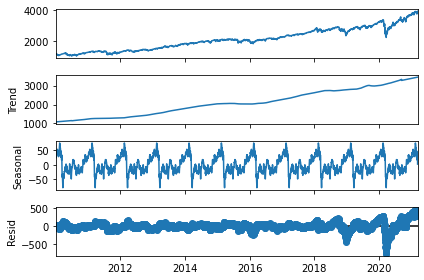

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(arima_train, model='additive',period=365,extrapolate_trend='freq')
result.plot()
plt.show()

## Verificando estacionariedade da série e da componente sasonal

In [44]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [41]:
# Componente sasonal
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


In [7]:
# série temporal
check_stationarity(arima_train['value'])

NameError: name 'check_stationarity' is not defined

## Plotando os gráficos de ACF e PCF da série

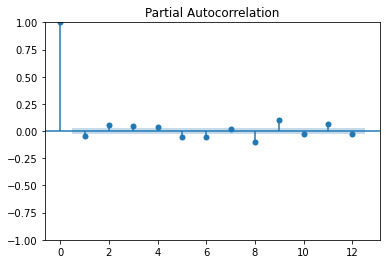

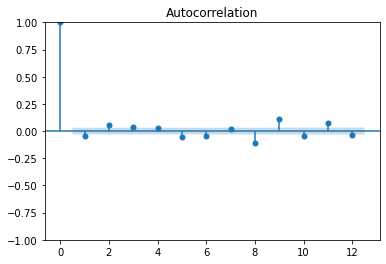

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(arima_train.diff().dropna(), lags =12)
plt.show()
plot_acf(arima_train.diff().dropna(), lags =12)
plt.show()

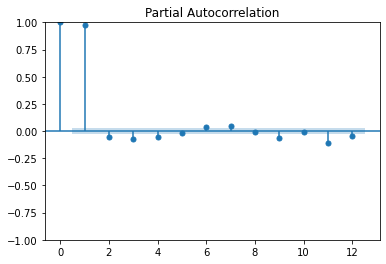

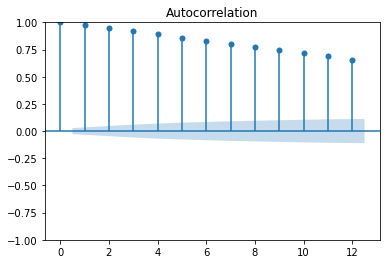

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()
plot_acf(seasonal, lags =12)
plt.show()

#### Analisando os gráficos pode ser visto que uma possível configuração pode ser pdq = 1,1,1 e PDQ = 0,0,1

In [8]:
ACF_PACF_config = [(3,1,3),(4,0,0, 12),'n']

# Parâmetros com auto arima

In [46]:
from pmdarima import auto_arima

# Suponha que 'data' seja a sua série temporal
auto_arima_config = auto_arima(arima_train, seasonal=True, m=12)  # m é o período da sazonalidade


KeyboardInterrupt



In [ ]:
# Obter os parâmetros 'order' e 'seasonal_order'
order = auto_arima_config.order
seasonal_order = auto_arima_config.seasonal_order
auto_arima_config = [order,seasonal_order,'n']
auto_arima_config

In [9]:
auto_arima_config = [(3,1,5),(2,0,0, 12),'n']

##### O Auto Arima retornou como parãmetros pdq = 3,1,5 e PDQ = 2,0,0 'n'

# Parâmetros com grid search

## Carregando funções

In [105]:
import itertools
def sarima_parameter_search(inicio, search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = range(inicio, search_range)
    d = [0,1,2]
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio = 4,search_range = 7)

In [10]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
def seasonal_arima_model(time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            
            return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf

In [37]:
#rmse,model, grid_search_melhor_conf, = grid_search([(5, 2, 6)],seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
rmse,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")

print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

NameError: name 'order_combos' is not defined

In [93]:
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

A melhor configuração para essa série temporal é:[(5, 2, 6), (1, 0, 1, 12), 'n']


In [99]:

model = SARIMAX(arima_train, 
                           order=(5, 1, 6), 
                           seasonal_order=(1, 1, 1, 12), 
                           trend = 'n',
                           enforce_stationarity=False, 
                           enforce_invertibility=False)
model_fit = model.fit()
prediction = model_fit.forecast(steps=len(arima_test))
rmse = np.sqrt(mean_squared_error(arima_test, prediction))

rmse

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


475.95914097470535

In [79]:
model = SARIMAX(arima_train, 
                           order=(0, 0, 1), 
                           seasonal_order=(1, 1, 1, 12), 
                           trend = 't',
                           enforce_stationarity=False, 
                           enforce_invertibility=False)
model_fit = model.fit()
prediction = model_fit.forecast(steps=len(arima_test))
rmse = np.sqrt(mean_squared_error(arima_test, prediction))

rmse

494.89716439682064

In [12]:
grid_search_melhor_conf = [(5,2,5),(1,0,1, 12),'n']


##### O grid search retornou os parâmetros pdq = 5,2,6 e PDQ = 1,0,1

# Selecionando a melhor configuração

In [13]:
configs = [ACF_PACF_config, auto_arima_config,grid_search_melhor_conf]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,mae_pred,mape_pred,model_fit,predicao = seasonal_arima_model(arima_train, config[0], config[1], config[2],len(arima_test),"SARIMA")
    if rmse_pred <= rmse or mae_pred <= mae or mape_pred <= mape :
        melhor_model = model_fit
        mae=mae_pred
        mape = mape_pred 
        melhor_predicao =  predicao
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}, mae:{mae}, mape:{mape}")

RMSE da config: [(3, 1, 3), (4, 0, 0, 12), 'n']- rmse:406.32686084289867, mae:338.29006702897317, mape:0.07697429121993458


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE da config: [(3, 1, 5), (2, 0, 0, 12), 'n']- rmse:406.32686084289867, mae:338.29006702897317, mape:0.07697429121993458


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE da config: [(5, 2, 5), (1, 0, 1, 12), 'n']- rmse:359.46577566479664, mae:314.77698443069664, mape:0.0754890095262667


#### a melhor configuração é pdq = 0,1,0 e PDQ =0,0,1

In [53]:
rmse_pred,mae_pred,mape_pred,model_fit,predicao= seasonal_arima_model(arima_train, (5, 2, 6), (1, 0, 1, 12),'n',len(arima_test),"SARIMA")
rmse_pred

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


358.12244408896794

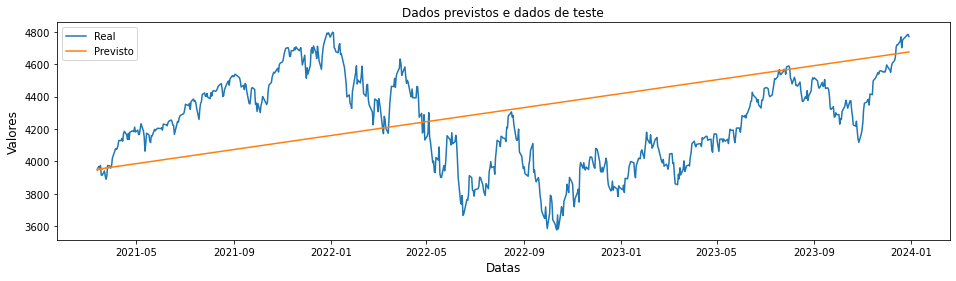

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Real")
plt.plot(melhor_predicao, label="Previsto")
plt.title('', fontsize=20)
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Dados previstos e dados de teste')
plt.legend()

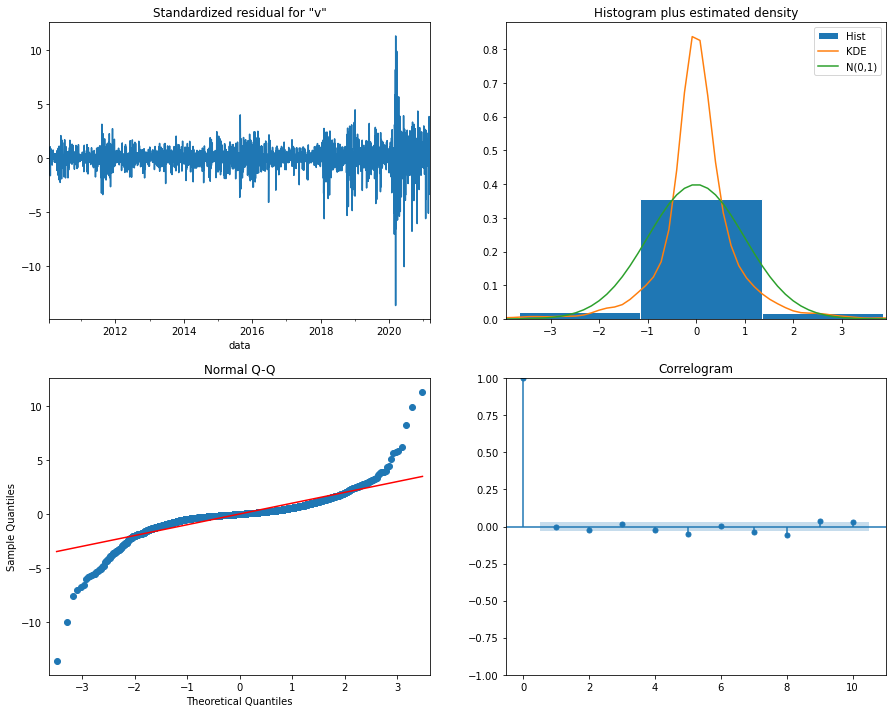

In [18]:
# Suponha que 'modelo_sarima' é o seu modelo SARIMA ajustado
melhor_model.plot_diagnostics(figsize=(15,12))
plt.show()


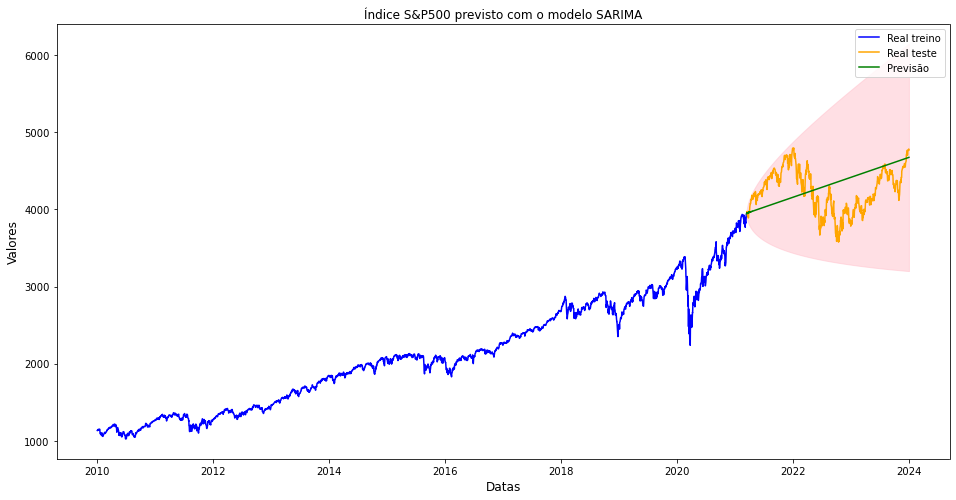

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model.get_forecast(steps=len(arima_test))
intervalo_confianca = previsoes.conf_int(alpha=0.05)
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice S&P500 previsto com o modelo SARIMA')

plt.legend()
plt.show()

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model.get_forecast(steps=len(arima_test),alpha=0.05)
intervalo_confianca = previsoes.conf_int()



C:\Users\alex\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


NameError: name 'previsoes' is not defined

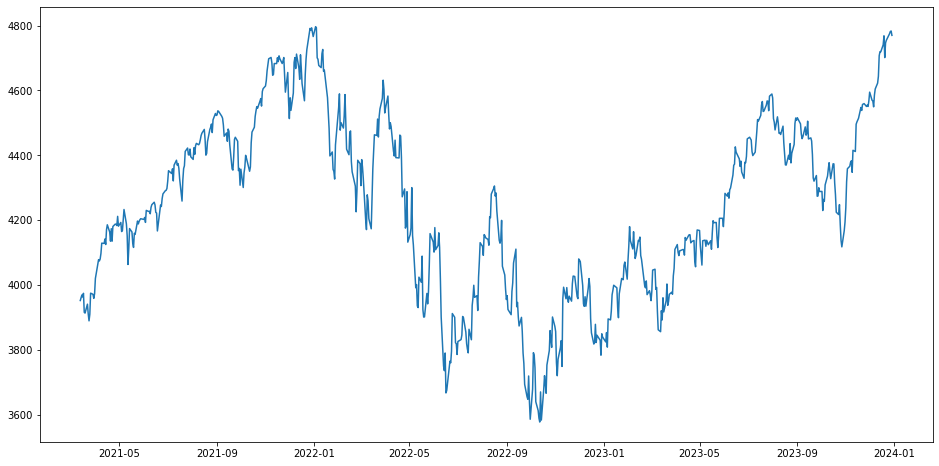

In [54]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_test.index, arima_test['value'], label='Observado')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='red', label='Previsões')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

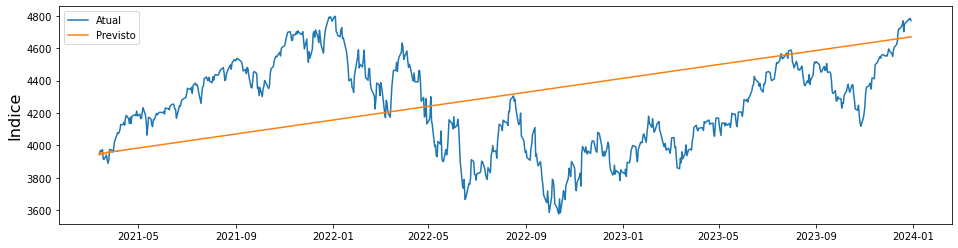

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Atual")
plt.plot(melhor_predicao, label="Previsto")
plt.title('', fontsize=20)
plt.ylabel('Indice', fontsize=16)
plt.legend()

# Prophet

## carregando dados

In [34]:
df = ler_csv('dados/SP_500.csv')
df_prophet = df_tratamento_dados(df)


In [35]:
len(df_prophet)

5108

## Adequando o df

In [36]:
df_prophet['ds'] = df_prophet.index.copy()
df_prophet.rename(columns={'value': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True, drop=True)
df_prophet.dropna(inplace=True)
df_prophet.tail(9)
len(df_prophet)

5108

## Separando treino e teste

In [37]:
prophet_train, prophet_test = split(df_prophet, 0.8) 

4086
1022


## Ajustando o modelo

In [38]:
# This function fits the prophet model to the input data and generates a forecast
from prophet import Prophet
def fit_and_forecast(df, periods, interval_width, changepoint_range=1):
    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)
    # Fit the model
    model.fit(df)
    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods,freq='D')
    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df
# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(prophet_train, len(prophet_test), 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,1024.891148,1212.670859,1121.008316
1,1026.436226,1218.269488,1124.193969
2,1027.350092,1224.044841,1126.375567
3,1028.660406,1221.471823,1127.499922
4,1040.993807,1230.631326,1128.957303


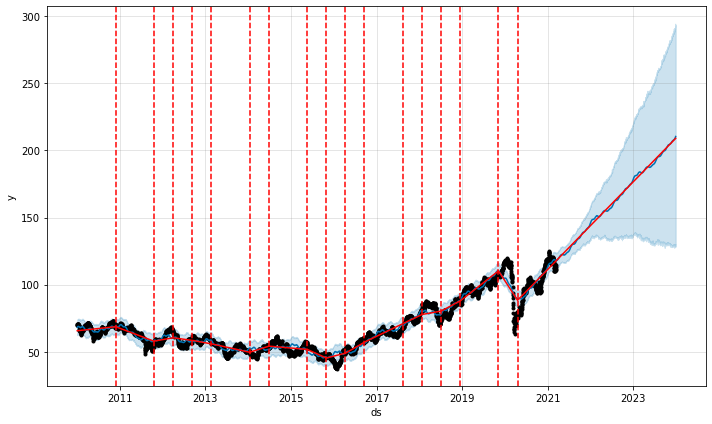

In [803]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

In [27]:
predicao = forecast_df[['ds','yhat']]
predicao = predicao[len(prophet_train):]

In [621]:
prophet_test

,y,ds
4596,106.472000,2022-08-05
4597,107.115333,2022-08-06
4598,107.758667,2022-08-07
4599,108.402000,2022-08-08
4600,108.651000,2022-08-09
...,...,...
5102,133.143000,2023-12-24
5103,133.338000,2023-12-25
5104,133.533000,2023-12-26
5105,134.194000,2023-12-27


In [623]:
rmse = np.sqrt(mean_squared_error(prophet_test['y'], predicao['yhat']))
rmse

7.821085174542876

## Ajuste de hiperparâmetros

In [46]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.01, 0.05, 0.1],
              'holidays_prior_scale': [5,10,15,20],
               'changepoint_range':[0.8,0.84,0.85,0.9],
              'n_changepoints' : [20,25,50,75,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 240


In [28]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.035,0.04, 0.05],
              'holidays_prior_scale': [10,15,20],
               'changepoint_range':[0.8,0.85,0.9],
              'n_changepoints' : [50,75,90,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 108


In [39]:
import holidays
import pandas as pd

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.US(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01              New Year's Day
1 2010-01-18  Martin Luther King Jr. Day
2 2010-02-15       Washington's Birthday
3 2010-05-31                Memorial Day
4 2010-07-04            Independence Day


In [47]:
import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


01:00:12 - cmdstanpy - INFO - Chain [1] start processing
01:00:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.3630572866423
total:  0.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:14 - cmdstanpy - INFO - Chain [1] start processing
01:00:16 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.34045711872307
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:17 - cmdstanpy - INFO - Chain [1] start processing
01:00:18 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.1938316816054
total:  1.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:20 - cmdstanpy - INFO - Chain [1] start processing
01:00:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.1146926797545
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:24 - cmdstanpy - INFO - Chain [1] start processing
01:00:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.0208630275
total:  2.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:32 - cmdstanpy - INFO - Chain [1] start processing
01:00:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.8086111549439
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:36 - cmdstanpy - INFO - Chain [1] start processing
01:00:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.4055042107615
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:38 - cmdstanpy - INFO - Chain [1] start processing
01:00:43 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.10454055203456
total:  3.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:45 - cmdstanpy - INFO - Chain [1] start processing
01:00:49 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.9122155009535
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:51 - cmdstanpy - INFO - Chain [1] start processing
01:00:53 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.90894042433007
total:  4.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:54 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.1779614859935
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:56 - cmdstanpy - INFO - Chain [1] start processing
01:00:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.8008739390018
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:00:58 - cmdstanpy - INFO - Chain [1] start processing
01:01:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 443.9987673648985
total:  5.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:05 - cmdstanpy - INFO - Chain [1] start processing
01:01:10 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.4239601966626
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:11 - cmdstanpy - INFO - Chain [1] start processing
01:01:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.00287060428286
total:  6.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:14 - cmdstanpy - INFO - Chain [1] start processing
01:01:15 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.3670135252215
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:16 - cmdstanpy - INFO - Chain [1] start processing
01:01:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.1685882103498
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:18 - cmdstanpy - INFO - Chain [1] start processing
01:01:22 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 444.24877770949905
total:  7.000000000000001
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:24 - cmdstanpy - INFO - Chain [1] start processing
01:01:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 445.260182811673
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:29 - cmdstanpy - INFO - Chain [1] start processing
01:01:32 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 446.9877829277378
total:  8.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 5, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:33 - cmdstanpy - INFO - Chain [1] start processing
01:01:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 463.2002068277393
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 5, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:38 - cmdstanpy - INFO - Chain [1] start processing
01:01:42 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 469.30592919665264
total:  9.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:45 - cmdstanpy - INFO - Chain [1] start processing
01:01:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 458.56553796703133
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:49 - cmdstanpy - INFO - Chain [1] start processing
01:01:51 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.13224254203203
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:52 - cmdstanpy - INFO - Chain [1] start processing
01:01:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.8409201525448
total:  10.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 10, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:55 - cmdstanpy - INFO - Chain [1] start processing
01:01:57 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 464.57790094775567
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 10, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:01:58 - cmdstanpy - INFO - Chain [1] start processing
01:01:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 457.13900309233895
total:  11.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:00 - cmdstanpy - INFO - Chain [1] start processing
01:02:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.17128082595946
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:05 - cmdstanpy - INFO - Chain [1] start processing
01:02:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 455.2122231706458
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 10, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:13 - cmdstanpy - INFO - Chain [1] start processing
01:02:17 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.9321723384709
total:  12.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 15, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:20 - cmdstanpy - INFO - Chain [1] start processing
01:02:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 464.5684028193277
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 15, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:27 - cmdstanpy - INFO - Chain [1] start processing
01:02:29 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 457.19638564094976
total:  13.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 15, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:34 - cmdstanpy - INFO - Chain [1] start processing
01:02:37 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.81057270545114
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 15, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:42 - cmdstanpy - INFO - Chain [1] start processing
01:02:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.21088025682224
total:  14.000000000000002
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 15, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:50 - cmdstanpy - INFO - Chain [1] start processing
01:02:54 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.65042906214126
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 20, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:02:56 - cmdstanpy - INFO - Chain [1] start processing
01:02:59 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 463.038725559626
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 20, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:03 - cmdstanpy - INFO - Chain [1] start processing
01:03:06 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 457.322851098294
total:  15.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 20, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:09 - cmdstanpy - INFO - Chain [1] start processing
01:03:13 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 455.14578716284433
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 20, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:16 - cmdstanpy - INFO - Chain [1] start processing
01:03:23 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 458.10127159699016
total:  16.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.84, 'holidays_prior_scale': 20, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:26 - cmdstanpy - INFO - Chain [1] start processing
01:03:30 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 456.30438321337857
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:32 - cmdstanpy - INFO - Chain [1] start processing
01:03:35 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 472.46175998694787
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:39 - cmdstanpy - INFO - Chain [1] start processing
01:03:41 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 467.30462628258914
total:  17.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:44 - cmdstanpy - INFO - Chain [1] start processing
01:03:47 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 468.6658867373691
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:49 - cmdstanpy - INFO - Chain [1] start processing
01:03:50 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 465.83375669447247
total:  18.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:52 - cmdstanpy - INFO - Chain [1] start processing
01:03:55 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 467.38476599237583
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 10, 'n_changepoints': 20, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:56 - cmdstanpy - INFO - Chain [1] start processing
01:03:58 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 473.75557432091426
total:  19.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 10, 'n_changepoints': 25, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:03:59 - cmdstanpy - INFO - Chain [1] start processing
01:04:02 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 472.93963472701574
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 10, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
01:04:05 - cmdstanpy - INFO - Chain [1] start processing
01:04:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 465.0889078789334
total:  20.0
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.85, 'holidays_prior_scale': 10, 'n_changepoints': 75, 'seasonality_mode': 'additive'}


C:\Users\alex\AppData\Local\Temp\ipykernel_22212\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


KeyboardInterrupt: 

In [48]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,443.998767,"{'changepoint_prior_scale': 0.01, 'changepoint...",372.986591,0.087435
1,444.248778,"{'changepoint_prior_scale': 0.01, 'changepoint...",371.988258,0.087166
2,444.340457,"{'changepoint_prior_scale': 0.01, 'changepoint...",370.925898,0.086886
3,444.363057,"{'changepoint_prior_scale': 0.01, 'changepoint...",371.091582,0.086927
4,444.405504,"{'changepoint_prior_scale': 0.01, 'changepoint...",370.783274,0.086847


In [54]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 443.9987673648985
MAE: 372.9865911871548
MAPE: 0.0874350499018795
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 15, 'n_changepoints': 50, 'seasonality_mode': 'additive'}


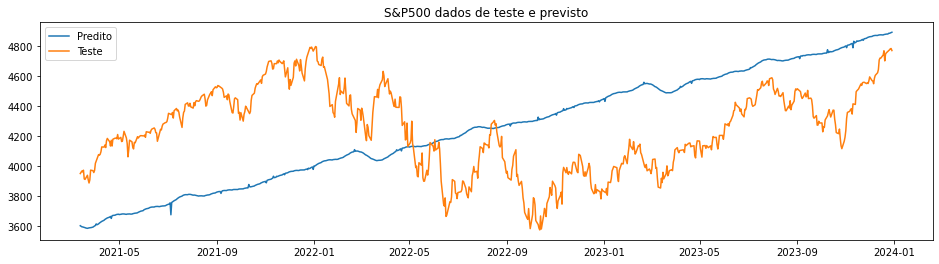

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
# Plotando o primeiro gráfico
plt.plot(predicao['ds'], predicao['yhat'], label='Predito')
# Plotando o segundo gráfico
plt.plot(prophet_test['ds'], prophet_test['y'], label='Teste')
# Adicionando uma legenda
plt.legend()
plt.title('S&P500 dados de teste e previsto')
# Exibindo o gráfico
plt.show()

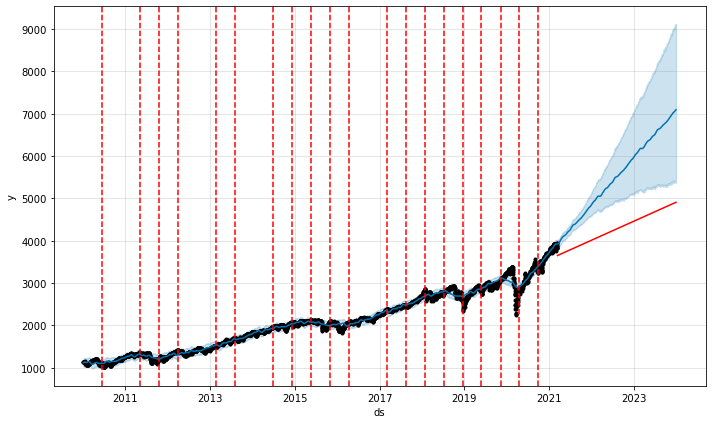

In [51]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, train_forecast)

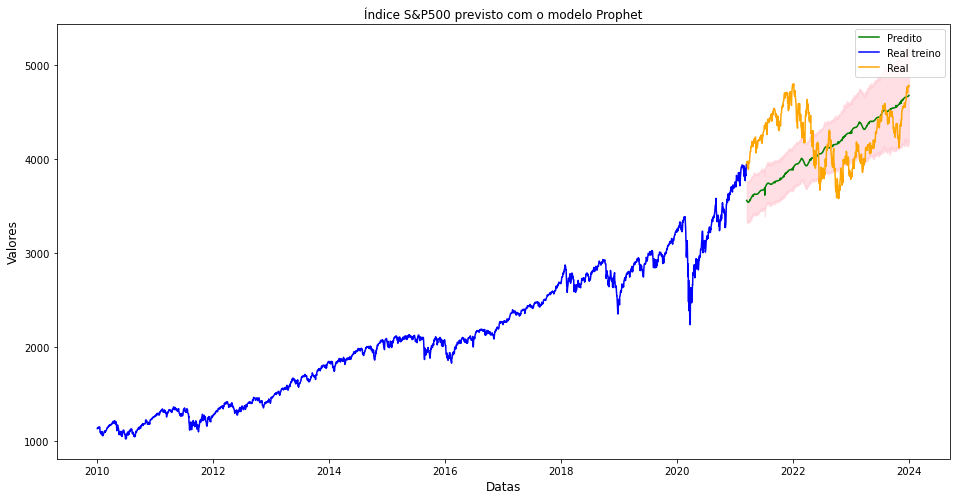

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')

# Área do intervalo de confiança
plt.fill_between(best_prediction['ds'],
                 best_prediction['yhat_upper'],
                 best_prediction['yhat_lower'], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice S&P500 previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [867]:
arima_test

,value
data,
2022-08-05,106.472000
2022-08-06,107.115333
2022-08-07,107.758667
2022-08-08,108.402000
2022-08-09,108.651000
...,...
2023-12-24,133.143000
2023-12-25,133.338000
2023-12-26,133.533000
